In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn

In [2]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

class IdentityModel(nn.Module):
    def __init__(self):
        super(IdentityModel, self).__init__()
        
    def forward(self, x, t):
        return x
    
def noise_estimation_loss(model,
                          x0: torch.Tensor,
                          t: torch.LongTensor,
                          e: torch.Tensor,
                          b: torch.Tensor, keepdim=False):

    a = (1-b).cumprod(dim=0).index_select(0, t).view(-1, 1,1)
    x = x0 * a.sqrt() + e * (1.0 - a).sqrt()

    output = model(x, t.float())
    if keepdim:
        return (e - output).square().sum(dim=(1, 2, 3))
    else:
        return (e - output).square().sum(dim=(1)).mean(dim=0), x


loss_registry = {
    'simple': noise_estimation_loss,
}

def generate_random_spiral_trajectories(num_trajectories, trajectory_length, a_range=(.9, 0.95), b_range=(0.2, 0.3)):
    """
    Generates spiral 2D trajectories with random a and b values.

    Parameters:
    num_trajectories (int): Number of trajectories to generate.
    trajectory_length (int): Length of each trajectory.
    a_range (tuple): Range of 'a' values for randomness.
    b_range (tuple): Range of 'b' values for randomness.

    Returns:
    torch.Tensor: A tensor of shape (num_trajectories, trajectory_length, 2) containing the trajectories.
    """
    # Initialize the trajectories tensor
    trajectories = torch.zeros(num_trajectories, trajectory_length, 2)
    
    # Generate spiral trajectories with random a and b values
    for i in range(num_trajectories):
        a = torch.FloatTensor(1).uniform_(*a_range).item()
        b = torch.FloatTensor(1).uniform_(*b_range).item()
        t = torch.linspace(0, 4 * np.pi, trajectory_length)
        r = a * torch.exp(b * t)
        x = r * torch.cos(t)
        y = r * torch.sin(t)
        trajectories[i, :, 0] = x
        trajectories[i, :, 1] = y
    
    return trajectories

def plot_forward_process(noisified, t):
    fig, ax = plt.subplots(3, noisified.shape[0])
    fig.set_size_inches(40,6)

    for i, (noisified_i, t_i) in enumerate(zip(noisified, t)):
        ax[0,i].plot(noisified_i[:, 0], noisified_i[:, 1])
        ax[0,i].axis('off')
        ax[0,i].set_title(f'{t_i}', size=8)

    for i, (noisified_i, t_i) in enumerate(zip(noisified, t)):
        ax[1,i].hist(noisified_i[:, 0])
        ax[1,i].axis('off')
        ax[1,i].set_title(f'x', size=8)

    for i, (noisified_i, t_i) in enumerate(zip(noisified, t)):
        ax[2,i].hist(noisified_i[:, 1])
        ax[2,i].axis('off')
        ax[2,i].set_title(f'y', size=8)
    
def plot_forward_process_hist(noisified, t):
    fig, ax = plt.subplots(2, noisified.shape[0])
    fig.set_size_inches(40,4)

    for i, (noisified_i, t_i) in enumerate(zip(noisified, t)):
        ax[0,i].hist(noisified_i[:, 0])
        ax[0,i].axis('off')
        ax[0,i].set_title(f'x', size=8)

    for i, (noisified_i, t_i) in enumerate(zip(noisified, t)):
        ax[1,i].hist(noisified_i[:, 1])
        ax[1,i].axis('off')
        ax[1,i].set_title(f'y', size=8)

def plot_forward_process_traj(noisified, t):
    fig, ax = plt.subplots(1, noisified.shape[0])
    fig.set_size_inches(40,2)

    for i, (noisified_i, t_i) in enumerate(zip(noisified, t)):
        ax[i].plot(noisified_i[:, 0], noisified_i[:, 1])
        ax[i].axis('off')
        ax[i].set_title(f'{t_i}', size=8)

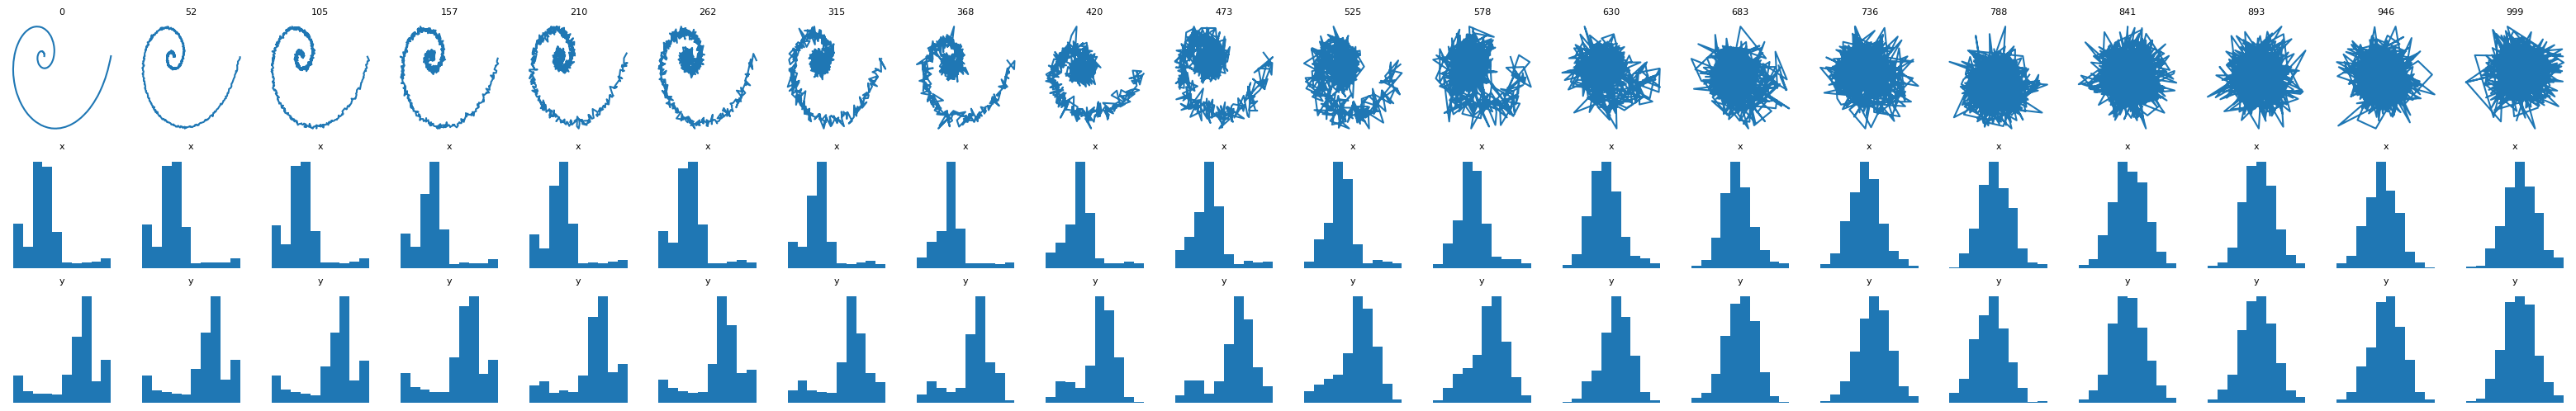

In [3]:
batch_size = 1
traj_len = 750
beta_schedule = 'linear'
beta_start = 0.0001
beta_end = 0.02
num_diffusion_timesteps = 1000
num_ims = num_diffusion_timesteps // 50

model = IdentityModel()

batch = generate_random_spiral_trajectories(batch_size, traj_len)
batch_rep = batch.repeat(num_ims,*[1]*len(batch.shape[1:]))

t = torch.linspace(0,num_diffusion_timesteps-1,num_ims,dtype=torch.long)

e = torch.randn_like(batch_rep)

betas = get_beta_schedule(
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    num_diffusion_timesteps=num_diffusion_timesteps,
)
b = betas = torch.from_numpy(betas).float()

loss, out = loss_registry['simple'](model, batch_rep, t, e, b)
plot_forward_process(out, t)

torch.Size([20, 750, 2])


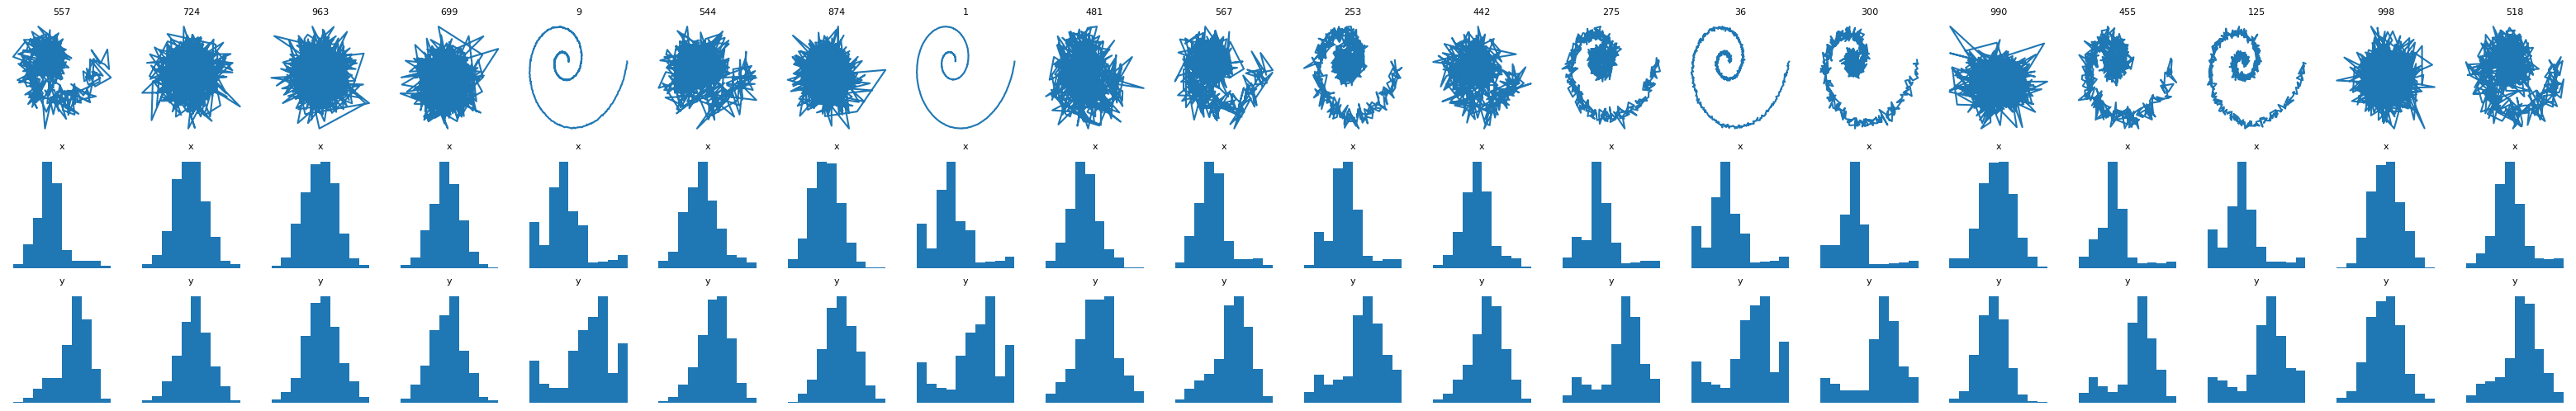

In [5]:
batch_size = 20
traj_len = 750
beta_schedule = 'linear'
beta_start = 0.0001
beta_end = 0.02
num_diffusion_timesteps = 1000

model = IdentityModel()

batch = generate_random_spiral_trajectories(batch_size, traj_len)
print(batch.shape)

n = batch.size(0)
# antithetic sampling
t = torch.randint(
    low=0, high=num_diffusion_timesteps, size=(n // 2 + 1,)
)
t = torch.cat([t, num_diffusion_timesteps - t - 1], dim=0)[:n]

e = torch.randn_like(batch)

betas = get_beta_schedule(
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    num_diffusion_timesteps=num_diffusion_timesteps,
)
b = betas = torch.from_numpy(betas).float()

loss, out = loss_registry['simple'](model, batch, t, e, b)
plot_forward_process(out, t)